# Recommender Systems

Recommender systems are useful for recommending users items based on their past preferences. Recommender systems are generally classified into the following categories:

- **Content-based** based on similarity of item attributes (e.g. keywords, categories) and users preferences: For instance, if a user liked Item A, the recommender system would recommend items with similar characteristics. If we would talk about movies, those characteristics would include producer, genre, etc... Typically, this can be done with a binary classification supervised algorithm.


- **Collaborative filtering**, which calculates similarity from interactions (e.g. ratings, number of purchases, likes, etc.). This process finds customers who have similar preferences, and then gives recommendations to one customer from a set of items that are new to that particular customer and preferred by other customers with a similar profile. The system makes an assumption that users with similar movie watching habits have similar preferences in general. It finds users who watch videos similar to those the user watches, then identifies videos those similar users have watched, but which the first user has not. There are 3 approaches to this; user-user collaborative filtering, item-item collaborative filtering and matrix factorization.


- New approaches and usually more powerful are **Hybrid systems**, which combine the two aforementioned methods.

<img src="data/image.png" width=600>

The above diagram categorises in detail the different methodologies for building a recommender system.

In context to the `movieLens` that will be used later as a sample dataset:
- We will suggest different movies based on the content similarity, e.g. genre, cast, etc. applying an item-content filtering
- We could also compare the user metadata, such as age and gender, and suggest items to the user that similar users have liked. In that case, we would use a user-content filtering. The `movielens` dataset doesn't contain any user content data, so we will build only an item-item collaborative filtering.

**Memory-based** content filtering

In memory-based methods there is no model that learns from the data to predict. A pre-computed matrix of similarities is constructed that can be used for movie predic

## Data collection and cleaning

__Load the datasets in three different pandas dataframes `movies`, `tags` and `ratings`.__

In [1]:
# YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')

display(movies.head())
display(tags.head())
display(ratings.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


__Remove the '|' that separates the different genres of movies and replace with an empty space.__

In [2]:
# YOUR CODE HERE
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.head()

/tmp/ipykernel_1689/3152722730.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres'] = movies['genres'].str.replace('|',' ')


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies = movies[movies.movieId.isin(ratings.movieId.unique().tolist())]
movies.shape

(9724, 3)

In [4]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation


__Filter the `movies` dataframe, to have only movies that have received a rating.__

### 🧪 Test your code

In [5]:
from nbresult import ChallengeResult

result = ChallengeResult('datasets', 
                         movies_shape=movies.shape, 
                         tags_shape=tags.shape, 
                         ratings_shape=ratings.shape, 
                         genres_cleaned=movies['genres'].str.find('|') >= 0)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/bitazaratustra/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/bitazaratustra/code/bitazaratustra/data-challenges/05-ML/06-Unsupervised-Learning/03-Movie-Recommendation
plugins: anyio-3.4.0
collecting ... collected 4 items

tests/test_datasets.py::TestDatasets::test_genres_are_cleaned PASSED     [ 25%]
tests/test_datasets.py::TestDatasets::test_movies_shape PASSED           [ 50%]
tests/test_datasets.py::TestDatasets::test_ratings_shape PASSED          [ 75%]
tests/test_datasets.py::TestDatasets::test_tags_shape PASSED             [100%]

============================== 4 passed in 0.37s ===============================


💯 You can commit your code:

git add tests/datasets.pickle

git commit -m 'Completed datasets step'

git push origin master


## Feature engineering

We're gonna create a new feature called `metadata`, that merges **all the text data information** we have about a movie : the genre and the tags.

__Merge the `movies` and `tags` dataframes.__

In [6]:
merged = pd.merge(movies, tags, on='movieId', how='left')
merged.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar,1.139046e+09
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar,1.137207e+09
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun,1.525286e+09
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy,1.528844e+09
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game,1.528844e+09


In [7]:
# YOUR CODE HERE
merged.fillna("", inplace=True)
merged = pd.DataFrame(merged.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
merged_df = pd.merge(movies, merged, on='movieId', how='left')
merged_df['metadata'] = merged_df[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)

merged_df.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy


__Create a new dataframe `merged_df` with the `metadata` column, containing a string of both tags AND genres merged together.__

So you have to merge **tags first** together per movie. And **then** merge the combined tags with the **genres** column.

For example the `metadata` column of the movie Toy Story will be `pixar pixar fun Adventure Animation Children Comedy Fantasy`.

👉 `merged_df` must contain at least the following columns: `movieId`, `title` and `metadata`.

### 🧪 Test your code

In [8]:
from nbresult import ChallengeResult
import numpy as np

result = ChallengeResult('feature_engineering', 
                         unique_movies=np.all(merged_df[['movieId']].value_counts() > 1), 
                         metadata=merged_df[merged_df['title'] == 'Copycat (1995)'], 
                         merged_df_rows=merged_df.shape[0])
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/bitazaratustra/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/bitazaratustra/code/bitazaratustra/data-challenges/05-ML/06-Unsupervised-Learning/03-Movie-Recommendation
plugins: anyio-3.4.0
collecting ... collected 4 items

tests/test_feature_engineering.py::TestFeatureEngineering::test_merged_df_rows PASSED [ 25%]
tests/test_feature_engineering.py::TestFeatureEngineering::test_metadata_has_genres PASSED [ 50%]
tests/test_feature_engineering.py::TestFeatureEngineering::test_metadata_has_tags PASSED [ 75%]
tests/test_feature_engineering.py::TestFeatureEngineering::test_unicity_of_movies PASSED [100%]

============================== 4 passed in 0.36s ===============================


💯 You can commit your code:

git add tests/feature_engineering.pickle

git commit -m 'Completed feature_engineering step'

## Create a content latent matrix from metadata

### Count Vectorizer

Next we need to transform the metadata text to vectors, in order to feed it to our machine learning algorithms. Machine Learning models don't understand text data so we need to encode it.

We're gonna use the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to encode the metadata column. 

Create a new dataframe `count_df` with the vectors you get from this count transformation. Every line is gonna be the frequency vector for this specific movie.

In [37]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(merged_df['metadata'])
count_df = pd.DataFrame(count_matrix.toarray(), index=merged_df.index.tolist())
count_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
count_df.shape

(9724, 1675)

### Dimensionality reduction

Each movie metadata was transformed into a vector of length ~1675!

As we saw in previous lessons, we can apply dimensionality reduction methods to describe the data (movies) without much loss of information. Truncated singular value decomposition (SVD) is another advanced tool to reduce dimensions.

Contrary to PCA, this estimator **does not center the data before computing the singular value decomposition**. This means it can work with **sparse matrices efficiently**. In particular, truncated SVD works on term count/frequency matrices. In that context, it is known as latent semantic analysis (LSA).

You can look at [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) class in scikit learn but it's the same principle as PCA.

__👉 Apply the truncated SVD with a reduced number of features (say 25) to reduce the dimension of your count matrix.__

In [63]:
# YOUR CODE HERE
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=25)
latent_df = svd.fit_transform(count_df)
n = 25 
latent_df = pd.DataFrame(latent_df[:,0:n], index=merged_df.title.tolist())
latent_df.shape

(9724, 25)

👉 **Plot the cumulative explained variance ratio as a function of the number of components.**

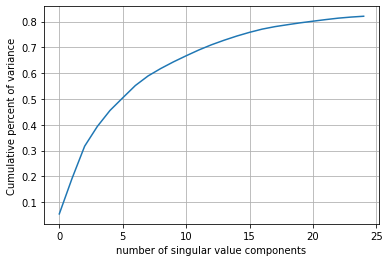

In [64]:
# YOUR CODE HERE
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

We can see that with only the first 25 components (from initially about 1700) we can explain **more than 80%** of the variance, which suffices for our study purposes.

👉 **Save the 25 components of this matrix into a new `latent_df` dataframe, indexed by the titles from the movies.**

In [65]:
# YOUR CODE HERE

### 🧪 Test your code

In [66]:
from nbresult import ChallengeResult

result =  ChallengeResult('metadata', 
                          counter_shape=count_df.shape, 
                          latent_shape=latent_df.shape)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/bitazaratustra/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/bitazaratustra/code/bitazaratustra/data-challenges/05-ML/06-Unsupervised-Learning/03-Movie-Recommendation
plugins: anyio-3.4.0
collecting ... collected 3 items

tests/test_metadata.py::TestMetadata::test_counter_columns PASSED        [ 33%]
tests/test_metadata.py::TestMetadata::test_counter_rows PASSED           [ 66%]
tests/test_metadata.py::TestMetadata::test_features_number PASSED        [100%]

============================== 3 passed in 0.04s ===============================


💯 You can commit your code:

git add tests/metadata.pickle

git commit -m 'Completed metadata step'

git push origin master


## Create a latent matrix from user ratings

Except from the metadata we have another valuable source of information, **the user ratings**. 

A recommender system can recommend a movie that is similar on the basis of user ratings (item-item collaborative filtering).

👉 **We prepare the dataset below to have movies as rows, `userId`s as columns.**

In [67]:
# Merge
ratings1 = pd.merge(movies[['movieId']], ratings, on="movieId", how="right")
# Pivot
ratings2 = ratings1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
display(ratings2.head())
ratings2.shape

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


(9724, 610)

We just created a dataset with users' ratings as vectors of length 9724.

👉**Once again, we will apply SVD to the `ratings2` dataframe, so as to keep only the first 200 components. Call this dataframe `latent_df_2`**

In [68]:
# YOUR CODE HERE
svd2 = TruncatedSVD(n_components=200)
latent_df_2 = svd2.fit_transform(ratings2)

**👉 Reindex by the film title.**

In [69]:
# YOUR CODE HERE
latent_df_2 = pd.DataFrame(latent_df_2, index=merged_df.title.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),37.649828,-6.380094,14.994617,0.286947,-1.887147,4.790050,8.807629,-2.198636,1.153305,1.387561,...,-0.982771,0.742340,-0.404205,-1.396094,-1.985031,-0.810153,-1.032169,0.648567,-2.173503,-1.032786
Jumanji (1995),20.596193,-0.477880,10.865916,-8.635795,-3.072411,-0.517149,4.359215,-3.821407,-3.394116,0.236473,...,-0.276959,0.624664,-0.218720,1.310705,1.245482,-0.117760,-0.410607,-0.984644,0.327427,-0.926750
Grumpier Old Men (1995),8.504182,-5.714924,3.441693,-6.382810,0.024162,-0.783433,-1.423027,-0.542292,3.270655,1.897237,...,0.546709,0.387720,0.623475,0.345185,0.010067,-0.308618,0.742269,0.979481,-0.550027,0.287662
Waiting to Exhale (1995),0.465720,-0.828101,0.954583,-0.239080,-0.735695,-0.877414,0.214720,-0.527368,0.079467,0.015617,...,-0.124433,-0.140787,0.044912,-0.014259,-0.170511,0.204789,-0.211548,-0.314366,0.160338,-0.185331
Father of the Bride Part II (1995),6.071045,-2.673536,4.698195,-4.415807,-3.714221,-1.673627,1.297653,-1.308023,1.325734,1.229592,...,0.832275,-0.180344,0.147301,0.313070,0.334068,0.679979,-0.411662,0.361589,1.072973,-0.620712


In [70]:
latent_df_2.shape

(9724, 200)

### 🧪 Test your code

In [71]:
from nbresult import ChallengeResult

result = ChallengeResult('ratings', latent_shape=latent_df_2.shape)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/bitazaratustra/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/bitazaratustra/code/bitazaratustra/data-challenges/05-ML/06-Unsupervised-Learning/03-Movie-Recommendation
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_ratings.py::TestRatings::test_latent_shape PASSED             [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/ratings.pickle

git commit -m 'Completed ratings step'

git push origin master


## Apply cosine similarity in content and colaborative matrices

Next, we will use a similarity measure to find the top $N$ **most similar movies to "Toy Story"** based on the filtering methods we created. Cosine similarity is one of the similarity measures we can use Scikit-learn [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html).

__👉 Compute the cosine similarity of a sample movie ("Toy Story") to both content (metadata) and collaborative (ratings) latent matrices.__

In [72]:
latent_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Toy Story (1995),0.906946,0.969612,0.642147,-0.496715,-0.916093,-0.982556,-0.730280,0.424489,0.068656,-0.213954,...,0.130426,-0.211220,-0.014317,-0.018596,0.003810,-0.039248,0.074834,-0.004061,-0.037685,-0.002368
Jumanji (1995),0.412993,0.161520,0.589471,-0.697434,-1.038275,-1.271058,-0.499947,0.377932,0.385751,0.340000,...,-0.576783,-0.207438,0.020372,0.017221,0.009744,-0.015245,0.090545,-0.019621,-0.014893,0.000476
Grumpier Old Men (1995),0.765626,0.916211,-0.122049,0.018001,0.281955,-0.207152,0.653873,0.063522,-0.031535,0.004238,...,0.012512,-0.061190,0.001084,-0.004299,-0.004156,0.005158,-0.004478,0.005908,-0.001246,-0.006257
Waiting to Exhale (1995),1.413731,0.503254,-0.641974,-0.225147,0.260513,-0.088929,0.437675,-0.028976,-0.023642,-0.003315,...,0.019016,-0.078481,-0.030055,-0.008138,-0.012146,-0.000817,-0.006723,0.005770,0.002901,-0.006312
Father of the Bride Part II (1995),0.523686,0.780103,0.056799,0.187916,0.098330,0.146743,-0.155329,-0.108346,-0.106465,0.029363,...,0.026957,-0.006599,-0.004277,-0.005794,-0.004673,0.011963,-0.004082,0.012744,-0.014607,-0.041078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.923350,0.707831,0.715075,-0.036019,-0.687505,-0.096936,-0.067330,-0.220352,0.447397,-0.731974,...,0.646229,-0.023754,-0.027648,-0.039753,0.004555,0.000105,0.083061,0.016737,-0.016733,-0.025366
No Game No Life: Zero (2017),0.677561,0.875247,0.265365,-0.083043,-0.268823,-0.424926,-0.435509,0.173466,0.286407,-0.471656,...,0.716771,-0.010545,-0.035977,-0.025905,0.026217,-0.013332,0.051013,0.033061,-0.011532,-0.019528
Flint (2017),0.648337,-0.412409,-0.520004,-0.243129,-0.021070,0.117877,-0.215087,-0.092358,0.007804,-0.007539,...,0.006576,-0.017691,-0.031130,-0.003886,-0.008037,-0.005909,-0.002304,-0.000053,0.004124,-0.000212
Bungo Stray Dogs: Dead Apple (2018),0.309432,-0.106349,0.551153,-0.081979,-0.588512,0.108112,0.193432,-0.182676,0.249515,-0.793534,...,0.597858,-0.010197,-0.022829,-0.021259,-0.006199,-0.002300,0.051502,-0.000269,-0.004426,-0.015307


In [73]:
# YOUR CODE HERE
from sklearn.metrics.pairwise import cosine_similarity

v1 = np.array(latent_df.loc['Toy Story (1995)']).reshape(1, -1)
v2 = np.array(latent_df_2.loc['Toy Story (1995)']).reshape(1, -1)

sim1 = cosine_similarity(latent_df, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

We can also create a hybrid filter, which is an average measure of similarity from both content and collaborative filtering. 

`hybrid_similarity = (content_similarity + collaborative_similarity) / 2`

__Calculate the average measure of both content and collaborative.__

In [75]:
# YOUR CODE HERE
hybrid = ((sim1 + sim2) / 2)

__Create a dataframe with the final similarities to Toy Story.__

In [76]:
# YOUR CODE HERE
dictDf = {'content': sim1 , 'collaborative': sim2, 'hybrid': hybrid} 
recommendation_df = pd.DataFrame(dictDf, index = latent_df.index)

__Sort your dataframe by most similar by collaborative similarity.__

In [82]:
# YOUR CODE HERE
recommendation_df.sort_values('collaborative', ascending=False, inplace=True)
recommendation_df.corr()

,content,collaborative,hybrid
content,1.000000,0.109911,0.928167
collaborative,0.109911,1.000000,0.471925
hybrid,0.928167,0.471925,1.000000


You should see Toy Story as the most similar movie of course (similarity of 1 for every column).

__You can sort on content as well as hybrid and see which one gives the best recommendation.__

In [81]:
# YOUR CODE HERE
recommendation_df.sort_values('hybrid', ascending=False)

,content,collaborative,hybrid
Toy Story (1995),1.000000,1.000000,1.000000
Toy Story 2 (1999),0.946789,0.637428,0.792109
"Monsters, Inc. (2001)",0.999661,0.551873,0.775767
Shrek (2001),0.912428,0.584861,0.748644
"Bug's Life, A (1998)",0.896112,0.537355,0.716734
...,...,...,...
Hommage à Zgougou (et salut à Sabine Mamou) (2002),0.000031,-0.051688,-0.025829
Spiral (2018),0.000031,-0.051688,-0.025829
Liquid Truth (2017),-0.000113,-0.051688,-0.025901
John From (2015),-0.000113,-0.051688,-0.025901


**❓ What similarity do you think is the better to build a realistic movie recommender system?  Assign it to the `best_similarity` variable**

In [83]:
a = 'content'
b = 'collaborative'
c = 'hybrid'
best_similarity = c 

### 🧪 Test your code

In [84]:
from nbresult import ChallengeResult

result = ChallengeResult('recommender', best_similarity=best_similarity)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/bitazaratustra/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/bitazaratustra/code/bitazaratustra/data-challenges/05-ML/06-Unsupervised-Learning/03-Movie-Recommendation
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_recommender.py::TestRecommender::test_best_similarity PASSED  [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/recommender.pickle

git commit -m 'Completed recommender step'

git push origin master


## 🏁 Good job!

You can commit and push your code on GitHub.